# <center style="color: #003b7f"> From Publication to Citation: Understanding the Factors <br/> Driving Research Recognition  </center> <a class='tocSkip'>
    
**MSDS 2023 Term 4 SLT1** | Loraine Menorca, BJ Enrik Yepes, Gregory del Carmen, Rozz Banquerigo

This notebook is dedicated to the details of the predictive modeling steps done and serves as a supplementary to the main report of this project.
    
**! Note:** This was run using PySpark via AWS EMR studio. Rerunning the entire notebook outside a similar environment is not advisable.
    
***

# Spark Initialization

In [1]:
spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1685605053939_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package('numpy')
sc.install_pypi_package('pandas')
sc.install_pypi_package('fsspec')
sc.install_pypi_package('s3fs ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Data Loading

In [5]:
fpath = 's3://s3bucketemr-sydney/processed/process_acl/derived_features_2023-05-30_21:55.parquet/'

df_processed = (spark.read.parquet(fpath,
                         header=True,
                         inferSchema=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Creating Opportunity Index

In [4]:
# from pyspark.sql import functions as F
# from pyspark.sql.window import Window

# # Calculate the percentage ranking of the target column (in this case: 'is-referenced-by-count')
# window = Window.orderBy(F.col('is-referenced-by-count'))
# test = df_processed.withColumn('cited_pct', F.percent_rank().over(window))

# # Calculate the opportunity_index column
# num_buckets = 2 
# bucket_labels = [0, 1]
# quantiles = [float(i) / num_buckets for i in range(1, num_buckets)]
# target_expr = 'CASE '
# for i, quantile in enumerate(quantiles):
#     bucket_label = bucket_labels[i]
#     target_expr += f'WHEN cited_pct <= {quantile} THEN {bucket_label} ' 
# target_expr += f'ELSE {bucket_labels[-1]} END'
# test = test.withColumn('opportunity_index', F.expr(target_expr))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
test = df_processed

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Investigating the Data

In [6]:
test.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- DOI: string (nullable = true)
 |-- title: string (nullable = true)
 |-- title_token_length: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- has_award: integer (nullable = true)
 |-- subject_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_subjects: integer (nullable = true)
 |-- num_funder_awards: integer (nullable = true)
 |-- num_funders: integer (nullable = true)
 |-- project_title: string (nullable = true)
 |-- project_description: string (nullable = true)
 |-- project_award_amount: double (nullable = true)
 |-- project_award_currency: string (nullable = true)
 |-- project_start_date: date (nullable = true)
 |-- project_end_date: date (nullable = true)
 |-- project_duration_days: integer (nullable = true)
 |-- institution_name: string (nullable = true)
 |-- institution_place: string (nullable = true)
 |-- num_authors: integer (nullable = true)
 |-- published_year: long (nullab

In [7]:
num_rows = test.count()  # Count the number of rows
num_cols = len(test.columns)  # Get the number of columns

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

# Create a DataFrame with the number of rows and columns
shape_data = [(num_rows, num_cols)]
shape_schema = "num_rows LONG, num_cols INT"
shape_df = spark.createDataFrame(shape_data, shape_schema)

# Show the shape DataFrame
shape_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  133294109
Number of columns:  28
+---------+--------+
| num_rows|num_cols|
+---------+--------+
|133294109|      28|
+---------+--------+

## Checking Each Column

In [8]:
test.select(['DOI', 'title', 'title_token_length', 'type', 'abstract', 'has_award',
             'subject_list', 'num_subjects', 'num_funder_awards', 'num_funders']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------------------+---------------+--------------------+---------+--------------------+------------+-----------------+-----------+
|                 DOI|               title|title_token_length|           type|            abstract|has_award|        subject_list|num_subjects|num_funder_awards|num_funders|
+--------------------+--------------------+------------------+---------------+--------------------+---------+--------------------+------------+-----------------+-----------+
|10.1001/2012.jama...|Expanding the Bou...|                 6|journal-article|                null|        0|  [General Medicine]|           1|             null|       null|
|10.1001/amaguides...|Clinical Update: ...|                 7|journal-article|                null|        0|                null|           0|             null|       null|
|10.1001/amaguides...|Clinical Update: ...|                 3|journal-article|<jats:title>Abstr...|        0|                null|

In [14]:
test.select('DOI').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                 DOI|
+--------------------+
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
|10.1001/archderm....|
+--------------------+
only showing top 20 rows

In [15]:
test.select('title').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|               title|
+--------------------+
|Umpolung of Imine...|
|ChemInform Abstra...|
|Radical Cyclizati...|
|Using the<i>DSM-I...|
|Temperature depen...|
|Functional Valida...|
|CBI-Based Assiste...|
|High Anion Gap Me...|
|Creating Linkages...|
|Empowering Women ...|
|Immersed Bodies i...|
|Ernährung und Ver...|
|           Dysphagie|
|Synthesis of Pyre...|
|Grundkurs Leistun...|
|    Slaapstoornissen|
|Influence of Phys...|
|Traffic Congestio...|
|Individual Differ...|
|Effectiveness of ...|
+--------------------+
only showing top 20 rows

In [86]:
test.select('title_token_length').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|title_token_length|
+------------------+
|                12|
|                 6|
|                 4|
|                 8|
|                11|
|                33|
|                36|
|                31|
|                19|
|                23|
|                21|
|                14|
|                16|
|                20|
|                 5|
|                15|
|                25|
|                24|
|                18|
|                28|
+------------------+
only showing top 20 rows

In [87]:
test.select('type').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|          type|
+--------------+
|posted-content|
|       dataset|
|        report|
+--------------+

In [52]:
test.select('abstract').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            abstract|
+--------------------+
|<jats:title>Abstr...|
|                null|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
|<jats:title>Abstr...|
+--------------------+
only showing top 20 rows

In [38]:
test.select('has_award').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|has_award|
+---------+
|        0|
+---------+

In [10]:
test.select('subject_list').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|        subject_list|
+--------------------+
|[Psychiatry and M...|
|[Cellular and Mol...|
|[Complementary an...|
|[Biomedical Engin...|
|[Industrial and M...|
|[Safety, Risk, Re...|
|[General Social S...|
|[General Economic...|
|[Medical Laborato...|
|[Political Scienc...|
|[Urban Studies, S...|
|[History and Phil...|
|[Electrical and E...|
|[General Social S...|
|[General Medicine...|
|[Law, Psychology ...|
|[Cognitive Neuros...|
|[Physiology (medi...|
|[Agricultural and...|
|[Industrial and M...|
+--------------------+
only showing top 20 rows

In [11]:
test.select('num_subjects').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|num_subjects|
+------------+
|          12|
|           1|
|           6|
|           3|
|           4|
|           8|
|          11|
|           5|
|           2|
|          13|
|          17|
|           7|
|           0|
|           9|
|          10|
+------------+

In [12]:
test.select('num_funder_awards').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|num_funder_awards|
+-----------------+
|               81|
|               12|
|             null|
|                1|
|                6|
|                3|
|               37|
|               35|
|                4|
|                8|
|               60|
|               11|
|               74|
|               19|
|               23|
|               21|
|               14|
|               16|
|                5|
|               15|
+-----------------+
only showing top 20 rows

In [13]:
test.select('num_funders').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|num_funders|
+-----------+
|         12|
|       null|
|          1|
|          6|
|          3|
|          4|
|          8|
|         11|
|         34|
|         19|
|        171|
|         95|
|         21|
|         14|
|         52|
|         16|
|         20|
|          5|
|         15|
|         25|
+-----------+
only showing top 20 rows

In [43]:
test.select('project_title',
            'project_description',
            'project_award_amount',
            'project_award_currency',
            'project_start_date',
            'project_end_date',
            'project_duration_days',
            'institution_name',
            'institution_place',
            'num_authors').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------------+--------------------+----------------------+------------------+----------------+---------------------+----------------+-----------------+-----------+
|project_title|project_description|project_award_amount|project_award_currency|project_start_date|project_end_date|project_duration_days|institution_name|institution_place|num_authors|
+-------------+-------------------+--------------------+----------------------+------------------+----------------+---------------------+----------------+-----------------+-----------+
|             |                   |                null|                  null|              null|            null|                 null|            null|                 |          5|
|             |                   |                null|                  null|              null|            null|                 null|            null|                 |         -1|
|             |                   |                null|                  n

In [19]:
test.select('project_title').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|project_title|
+-------------+
|             |
+-------------+

In [20]:
test.select('project_description').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|project_description|
+-------------------+
|                   |
+-------------------+

In [21]:
test.select('project_award_amount').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|project_award_amount|
+--------------------+
|                null|
+--------------------+

In [22]:
test.select('project_award_currency').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|project_award_currency|
+----------------------+
|                  null|
+----------------------+

In [39]:
test.select('project_start_date').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|project_start_date|
+------------------+
|              null|
+------------------+

In [23]:
test.select('project_end_date').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|project_end_date|
+----------------+
|            null|
+----------------+

In [41]:
test.select('project_duration_days').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|project_duration_days|
+---------------------+
|                 null|
+---------------------+

In [24]:
test.select('institution_name').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|    institution_name|
+--------------------+
|  Ryerson University|
|Partnership for t...|
|              ISRCTN|
|Stockholm Interna...|
|Washington Procur...|
|Otto-Friedrich-Un...|
|Public Health Sco...|
|Joint UN Programm...|
|                null|
|Ontario COVID-19 ...|
|European Forest I...|
|Corporación Colom...|
|Joint Transportat...|
|Nevada Test Site/...|
|      Review Commons|
|Lawrence Berkeley...|
|Los Alamos Nation...|
|Washington Closur...|
|  University of Iowa|
|Instituto Tecnoló...|
+--------------------+
only showing top 20 rows

In [25]:
test.select('institution_place').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|   institution_place|
+--------------------+
|Los Alamos, NM (U...|
|    Toulouse, France|
|Mosquera, (Colombia)|
|              Bergen|
|      Houston, Texas|
|       Cambridge, MA|
|   Oak Ridge, TN USA|
|West Conshohocken...|
|          London, UK|
| La Laguna, Tenerife|
|          Bogotá, DC|
|East Lansing, Mic...|
|         New Zealand|
|      Morgantown, WV|
|            Scotland|
|               Cairo|
|Niskayuna, NY (Un...|
|Boston, Massachus...|
| Ann Arbor, Michigan|
|      Washington, DC|
+--------------------+
only showing top 20 rows

In [27]:
test.select('num_authors').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|num_authors|
+-----------+
|         65|
|        133|
|         81|
|         76|
|         12|
|        209|
|        122|
|          1|
|          6|
|          3|
|        142|
|         92|
|         64|
|         37|
|         61|
|        107|
|       1108|
|         35|
|          4|
|          8|
+-----------+
only showing top 20 rows

In [28]:
test.select(['published_year',
             'published_month',
             'published_day',
             'issn_type',
             'isbn_type',
             'is-referenced-by-count',
             'affiliation_list',
             'num_affiliations',
             'cited_pct',
             'opportunity_index']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+---------------+-------------+---------+---------+----------------------+--------------------+----------------+---------+-----------------+
|published_year|published_month|published_day|issn_type|isbn_type|is-referenced-by-count|    affiliation_list|num_affiliations|cited_pct|opportunity_index|
+--------------+---------------+-------------+---------+---------+----------------------+--------------------+----------------+---------+-----------------+
|          2020|              3|            1|    print|     null|                     0|                [, ]|               0|      0.0|                0|
|          1943|              7|         null|    print|     null|                     0|                  []|               0|      0.0|                0|
|          1970|              4|            1|    print|     null|                     0|                  []|               0|      0.0|                0|
|          1954|              5|         null|    print|     nul

In [29]:
test.select('published_year').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|published_year|
+--------------+
|          1951|
|          1782|
|          1921|
|          1882|
|          1983|
|          1905|
|          1988|
|          1986|
|          1908|
|          1895|
|          1937|
|          1771|
|          1811|
|          1918|
|          1942|
|          1826|
|          1778|
|          1935|
|          1810|
|          1795|
+--------------+
only showing top 20 rows

In [30]:
test.select('published_month').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+
|published_month|
+---------------+
|           null|
|              5|
|              6|
|              9|
|              1|
|             10|
|              3|
|             12|
|             11|
|              2|
|              7|
|              8|
|              4|
+---------------+

In [31]:
test.select('published_day').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|published_day|
+-------------+
|           25|
|         null|
|           18|
|           21|
|           29|
|           27|
|           17|
|            5|
|           19|
|           22|
|            6|
|           26|
|            9|
|            1|
|           10|
|            3|
|           12|
|           11|
|            2|
|           13|
+-------------+
only showing top 20 rows

In [32]:
test.select('issn_type').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
| issn_type|
+----------+
|      null|
|electronic|
|     print|
+----------+

In [33]:
test.select('isbn_type').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
| isbn_type|
+----------+
|      null|
|electronic|
|     print|
+----------+

In [34]:
test.select('is-referenced-by-count').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|is-referenced-by-count|
+----------------------+
|                   474|
|                    65|
|                   541|
|                   558|
|                   418|
|                  1224|
|                   243|
|                  2857|
|                   385|
|                    77|
|                  1505|
|                   463|
|                   188|
|                   274|
|                    94|
|                   149|
|                   600|
|                   439|
|                   902|
|                   343|
+----------------------+
only showing top 20 rows

In [35]:
test.select('affiliation_list').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|    affiliation_list|
+--------------------+
|[Department\rof M...|
|[8sens.biognostic...|
|[Department of Ch...|
|[University of Ce...|
|[Science, AAAS, C...|
|[Brigham Young Un...|
|[Central Laborato...|
|[Universidade Fed...|
|[U.S. Department ...|
|[Preussag Noell G...|
|[Division of Rena...|
|[Iowa State Unive...|
|[NICT National In...|
|[Department of Ma...|
|[*Centre for the ...|
|[Assistant Profes...|
|[Otto-von-Guerick...|
|[Derriford Hospit...|
|[Mechanical Engin...|
|[KU Leuven, Rega ...|
+--------------------+
only showing top 20 rows

In [36]:
test.select('num_affiliations').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|num_affiliations|
+----------------+
|              12|
|            null|
|               1|
|               6|
|               3|
|              37|
|              61|
|              35|
|               4|
|               8|
|              87|
|              11|
|              33|
|              83|
|              99|
|              36|
|              31|
|              85|
|              34|
|              44|
+----------------+
only showing top 20 rows

In [37]:
test.select('cited_pct').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|         cited_pct|
+------------------+
|               0.0|
|0.5245540635599587|
|0.6120665438565371|
|0.6588117533297121|
|0.6917121572995559|
|0.7173363881920423|
|0.7383668451421723|
|0.7562493084840629|
|0.7717723652121218|
|0.7854986358436788|
|0.7977185083079591|
|0.8087475104300934|
|0.8187641722318288|
|0.8279135413847399|
|0.8362957798554757|
|0.8440231581729029|
|0.8511579896689807|
|0.8577800378093231|
|0.8639313899756169|
|0.8696637138679828|
+------------------+
only showing top 20 rows

In [44]:
test.select('opportunity_index').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|opportunity_index|
+-----------------+
|                0|
|                1|
+-----------------+

In [42]:
test.select('opportunity_index').groupBy('opportunity_index').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------+
|opportunity_index|   count|
+-----------------+--------+
|                0|69919966|
|                1|63374143|
+-----------------+--------+

# Filtering Usable Columns

In [8]:
from pyspark.sql.functions import col
df = test.select(['DOI', 'title', 'title_token_length', 'type', 'abstract', 'subject_list',
                  'num_subjects', 'num_funder_awards', 'num_funders', 'institution_name',
                  'institution_place', 'num_authors', 'published_year', 'published_month',
                  'published_day', 'issn_type', 'isbn_type', 'is-referenced-by-count',
                  'affiliation_list', 'num_affiliations'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df_columns = ['DOI', 'title', 'title_token_length', 'type', 'abstract', 'subject_list',
              'num_subjects', 'num_funder_awards', 'num_funders', 'institution_name',
              'institution_place', 'num_authors', 'published_year', 'published_month',
              'published_day', 'issn_type', 'isbn_type', 'is-referenced-by-count',
              'affiliation_list', 'num_affiliations']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- DOI: string (nullable = true)
 |-- title: string (nullable = true)
 |-- title_token_length: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- subject_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_subjects: integer (nullable = true)
 |-- num_funder_awards: integer (nullable = true)
 |-- num_funders: integer (nullable = true)
 |-- institution_name: string (nullable = true)
 |-- institution_place: string (nullable = true)
 |-- num_authors: integer (nullable = true)
 |-- published_year: long (nullable = true)
 |-- published_month: long (nullable = true)
 |-- published_day: long (nullable = true)
 |-- issn_type: string (nullable = true)
 |-- isbn_type: string (nullable = true)
 |-- is-referenced-by-count: long (nullable = true)
 |-- affiliation_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_affiliations: integer (nullable = true)
 |-- cited_pct:

In [57]:
df.select(df_columns[:9]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+
|                 DOI|               title|title_token_length|           type|            abstract|        subject_list|num_subjects|num_funder_awards|num_funders|
+--------------------+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+
|10.1001/2012.jama...|Expanding the Bou...|                 6|journal-article|                null|  [General Medicine]|           1|             null|       null|
|10.1001/amaguides...|Clinical Update: ...|                 7|journal-article|                null|                null|           0|             null|       null|
|10.1001/amaguides...|Clinical Update: ...|                 3|journal-article|<jats:title>Abstr...|                null|           0|             null|       null|
|10.1001/amajeth

In [61]:
df.select(df_columns[9:17]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----------------+-----------+--------------+---------------+-------------+----------+---------+
|institution_name|institution_place|num_authors|published_year|published_month|published_day| issn_type|isbn_type|
+----------------+-----------------+-----------+--------------+---------------+-------------+----------+---------+
|            null|                 |          5|          2013|              1|           28|     print|     null|
|            null|                 |         -1|          2020|             12|            1|electronic|     null|
|            null|                 |          1|          1976|              2|            1|     print|     null|
|            null|                 |          1|          1977|              8|            1|     print|     null|
|            null|                 |          1|          1978|             12|            1|     print|     null|
|            null|                 |          1|          1982|             11| 

In [62]:
df.select(df_columns[17:22]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+----------------+----------------+---------+-----------------+
|is-referenced-by-count|affiliation_list|num_affiliations|cited_pct|opportunity_index|
+----------------------+----------------+----------------+---------+-----------------+
|                     0|              []|               0|      0.0|                0|
|                     0|[, , , , , , , ]|               0|      0.0|                0|
|                     0|          [, , ]|               0|      0.0|                0|
|                     0|            null|            null|      0.0|                0|
|                     0|            null|            null|      0.0|                0|
|                     0|            null|            null|      0.0|                0|
|                     0|              []|               0|      0.0|                0|
|                     0|            null|            null|      0.0|                0|
|                     0|            null|  

In [47]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- DOI: string (nullable = true)
 |-- title: string (nullable = true)
 |-- title_token_length: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- subject_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_subjects: integer (nullable = true)
 |-- num_funder_awards: integer (nullable = true)
 |-- num_funders: integer (nullable = true)
 |-- institution_name: string (nullable = true)
 |-- institution_place: string (nullable = true)
 |-- num_authors: integer (nullable = true)
 |-- published_year: long (nullable = true)
 |-- published_month: long (nullable = true)
 |-- published_day: long (nullable = true)
 |-- issn_type: string (nullable = true)
 |-- isbn_type: string (nullable = true)
 |-- is-referenced-by-count: long (nullable = true)
 |-- affiliation_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_affiliations: integer (nullable = true)
 |-- cited_pct:

In [38]:
from pyspark.sql.functions import col, when, array, regexp_replace, desc

# 1. Remove the rows ['is-referenced-by-count', 'cited_pct', 'isbn_type'], we drop isbn types because we are interested in research papers and journals, not books
# df_cleaned = df.drop('is-referenced-by-count', 'cited_pct', 'isbn_type')
df_cleaned = df.drop('isbn_type', 'DOI')

# 2. Remove rows that are null or blank in all three columns of ['DOI', 'title', 'abstract'], then convert the remaining null values to Blanks
df_cleaned = df_cleaned.filter((col('title').isNotNull()) & (col('abstract').isNotNull()))
df_cleaned = df_cleaned.na.fill({'title': '', 'abstract': ''})

# 3. Remove rows with null values in Numerical['title_token_length', 'num_subjects', 'num_funder_awards', 'num_funders', 'num_authors', 'num_affiliations']
df_cleaned = df_cleaned.dropna(subset=['title_token_length', 'num_subjects', 'num_funder_awards', 'num_funders', 'num_authors', 'num_affiliations'])

# 4. Remove rows with null values in ['type', 'issn_type']
df_cleaned = df_cleaned.dropna(subset=['type', 'issn_type'])

# 5. Remove rows with null values in ['subject_list', 'affiliation_list']
df_cleaned = df_cleaned.dropna(subset=['subject_list', 'affiliation_list'])

# 6. Convert null values to 'None' (string) in ['institution_name', 'institution_place']
df_cleaned = df_cleaned.withColumn('institution_name', when(col('institution_name').isNull(), 'None').otherwise(col('institution_name')))
df_cleaned = df_cleaned.withColumn('institution_place', when(col('institution_place').isNull(), 'None').otherwise(col('institution_place')))

# 7. Impute the mode to published_month and published_day
# Calculate the mode value for 'published_month' and 'published_day'
# mode_published_month = df_cleaned.groupBy('published_month').count().dropna(subset=['published_month']).orderBy(desc('count')).first()[0] # mode = 1
# mode_published_day = df_cleaned.groupBy('published_day').count().dropna(subset=['published_day']).orderBy(desc('count')).first()[0] # mode = 1
mode_published_month = 1
mode_published_day = 1

# Impute the mode value to the null values in 'published_month' and 'published_day'
df_cleaned = df_cleaned.withColumn('published_month', when(col('published_month').isNull(), mode_published_month).otherwise(col('published_month')))
df_cleaned = df_cleaned.withColumn('published_day', when(col('published_day').isNull(), mode_published_day).otherwise(col('published_day')))

# 8. Convert ['opportunity_index'] to float
# df_cleaned = df_cleaned.withColumn('opportunity_index', col('opportunity_index').cast('float'))

# 9. Remove headers, leading "Abstract", and leading/trailing white spaces from the abstract column
df_cleaned = df_cleaned.withColumn("abstract", regexp_replace(df_cleaned["abstract"], r"<[^>]+>", ""))
df_cleaned = df_cleaned.withColumn("abstract", regexp_replace(df_cleaned["abstract"], r"^\s*(Abstract\s*)?", ""))
df_cleaned = df_cleaned.withColumn("abstract", regexp_replace(df_cleaned["abstract"], r"^\s+|\s+$", ""))
df_cleaned = df_cleaned.withColumn("abstract", regexp_replace(df_cleaned["abstract"], "Abstract\\n", ""))

# 10. Fix [, , ,] types of arrays in ['subject_list', subject_list'] to []
df_cleaned = df_cleaned.withColumn('subject_list', when((col('num_subjects') == 0), array()).otherwise(col('subject_list')))
df_cleaned = df_cleaned.withColumn('affiliation_list', when((col('num_affiliations') == 0), array()).otherwise(col('affiliation_list')))

# List of numerical columns
numerical_cols = ['title_token_length', 'num_subjects', 'num_funder_awards', 'num_funders', 'num_authors', 'num_affiliations']

# Replace negative values with zero
for col_name in numerical_cols:
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name) < 0, 0).otherwise(col(col_name)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
df_cleaned.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2031463

In [22]:
from pyspark.sql.functions import col, sum

# Show the count of null values per column
null_counts = df_cleaned.select([sum(col(column).isNull().cast('int')).alias(column) for column in df_cleaned.columns])
null_counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+----+--------+------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+---------+----------------------+----------------+----------------+
|title|title_token_length|type|abstract|subject_list|num_subjects|num_funder_awards|num_funders|institution_name|institution_place|num_authors|published_year|published_month|published_day|issn_type|is-referenced-by-count|affiliation_list|num_affiliations|
+-----+------------------+----+--------+------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+---------+----------------------+----------------+----------------+
|    0|                 0|   0|       0|           0|           0|                0|          0|               0|                0|          0|             0|              0|            0|        0|                     0|           

In [9]:
null_counts.select(null_counts.columns[:10]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+------------------+----+--------+------------+------------+-----------------+-----------+----------------+
|DOI|title|title_token_length|type|abstract|subject_list|num_subjects|num_funder_awards|num_funders|institution_name|
+---+-----+------------------+----+--------+------------+------------+-----------------+-----------+----------------+
|  0|    0|                 0|   0|       0|           0|           0|                0|          0|               0|
+---+-----+------------------+----+--------+------------+------------+-----------------+-----------+----------------+

In [10]:
null_counts.select(null_counts.columns[-9:]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----------+--------------+---------------+-------------+---------+----------------+----------------+-----------------+
|institution_place|num_authors|published_year|published_month|published_day|issn_type|affiliation_list|num_affiliations|opportunity_index|
+-----------------+-----------+--------------+---------------+-------------+---------+----------------+----------------+-----------------+
|                0|          0|             0|              0|            0|        0|               0|               0|                0|
+-----------------+-----------+--------------+---------------+-------------+---------+----------------+----------------+-----------------+

In [40]:
num_rows = df_cleaned.count()  # Count the number of rows
num_cols = len(df_cleaned.columns)  # Get the number of columns

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

# Create a DataFrame with the number of rows and columns
shape_data = [(num_rows, num_cols)]
shape_schema = "num_rows LONG, num_cols INT"
shape_df_cleaned = spark.createDataFrame(shape_data, shape_schema)

# Show the shape DataFrame
shape_df_cleaned.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  2031463
Number of columns:  18
+--------+--------+
|num_rows|num_cols|
+--------+--------+
| 2031463|      18|
+--------+--------+

In [13]:
df_cleaned.select('is-referenced-by-count').groupBy('is-referenced-by-count').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-----+
|is-referenced-by-count|count|
+----------------------+-----+
|                    65| 1313|
|                    77|  828|
|                    94|  519|
|                    25| 9509|
|                   124|  254|
|                    58| 1575|
|                    56| 1730|
|                    79|  791|
|                    41| 3623|
|                    33| 5527|
|                    96|  496|
|                   356|   14|
|                   106|  379|
|                   177|   79|
|                   132|  201|
|                   154|  146|
|                   162|  129|
|                   176|  107|
|                    36| 4624|
|                    78|  761|
+----------------------+-----+
only showing top 20 rows

# Saving the Preprocessed Data 

In [42]:
# Define the output paths for saving the dataframes
output_path_preprocessed = "s3://s3bucketemr-sydney/cleaned_3/ml_data"
output_path_null_counts = "s3://s3bucketemr-sydney/cleaned_3/null_counts.csv"
output_path_shape = "s3://s3bucketemr-sydney/cleaned_3/df_shape.csv"

# Save preprocessed_df as parquet
df_cleaned.write.mode('overwrite').parquet(output_path_preprocessed)

# Save null_counts as CSV
null_counts.toPandas().to_csv(output_path_null_counts, header=True, index=False)

# Save shape_df as CSV
shape_df_cleaned.toPandas().to_csv(output_path_shape, header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Reloading the Cleaned Data

In [43]:
fpath = "s3://s3bucketemr-sydney/cleaned_3/ml_data"

df_processed = (spark.read.parquet(fpath,
                         header=True,
                         inferSchema=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Creating Opportunity Index

In [45]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Calculate the percentage ranking of the target column (in this case: 'is-referenced-by-count')
window = Window.orderBy(F.col('is-referenced-by-count'))
test = df_processed.withColumn('cited_pct', F.percent_rank().over(window))

# Calculate the opportunity_index column
num_buckets = 2 
bucket_labels = [0, 1]
quantiles = [float(i) / num_buckets for i in range(1, num_buckets)]
target_expr = 'CASE '
for i, quantile in enumerate(quantiles):
    bucket_label = bucket_labels[i]
    target_expr += f'WHEN cited_pct <= {quantile} THEN {bucket_label} ' 
target_expr += f'ELSE {bucket_labels[-1]} END'
test = test.withColumn('opportunity_index', F.expr(target_expr))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
test.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+---------+----------------------+----------------+----------------+---------+-----------------+
|                 DOI|               title|title_token_length|           type|            abstract|        subject_list|num_subjects|num_funder_awards|num_funders|institution_name|institution_place|num_authors|published_year|published_month|published_day|issn_type|is-referenced-by-count|affiliation_list|num_affiliations|cited_pct|opportunity_index|
+--------------------+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+---------+----------------------+----------

In [46]:
test.select('opportunity_index').groupBy('opportunity_index').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+
|opportunity_index|  count|
+-----------------+-------+
|                0|1060056|
|                1| 971407|
+-----------------+-------+

# Saving the Data with Opportunity Index

In [47]:
# Define the output paths for saving the dataframes
output_path_preprocessed_test = "s3://s3bucketemr-sydney/cleaned_3/opportunity_data"

# Save preprocessed_df as parquet
test.write.mode('overwrite').parquet(output_path_preprocessed_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Reloading the Data with Opportunity Index

In [3]:
fpath = "s3://s3bucketemr-sydney/cleaned_3/opportunity_data"

df_cleaned = (spark.read.parquet(fpath,
                         header=True,
                         inferSchema=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
df_cleaned.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- title_token_length: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- subject_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_subjects: integer (nullable = true)
 |-- num_funder_awards: integer (nullable = true)
 |-- num_funders: integer (nullable = true)
 |-- institution_name: string (nullable = true)
 |-- institution_place: string (nullable = true)
 |-- num_authors: integer (nullable = true)
 |-- published_year: long (nullable = true)
 |-- published_month: long (nullable = true)
 |-- published_day: long (nullable = true)
 |-- issn_type: string (nullable = true)
 |-- is-referenced-by-count: long (nullable = true)
 |-- affiliation_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_affiliations: integer (nullable = true)
 |-- cited_pct: double (nullable = true)
 |-- opportunity_index: integer (nullable = true)

In [50]:
num_rows = df_cleaned.count()  # Count the number of rows
num_cols = len(df_cleaned.columns)  # Get the number of columns

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

# Create a DataFrame with the number of rows and columns
shape_data = [(num_rows, num_cols)]
shape_schema = "num_rows LONG, num_cols INT"
shape_df = spark.createDataFrame(shape_data, shape_schema)

# Show the shape DataFrame
shape_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  2031463
Number of columns:  20
+--------+--------+
|num_rows|num_cols|
+--------+--------+
| 2031463|      20|
+--------+--------+

In [51]:
df_cleaned.select('opportunity_index').groupBy('opportunity_index').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+
|opportunity_index|  count|
+-----------------+-------+
|                0|1060056|
|                1| 971407|
+-----------------+-------+

In [151]:
df_sampled.select('subject_list').groupBy('subject_list').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|        subject_list|count|
+--------------------+-----+
|[General Material...|    8|
|[Economics and Ec...|    1|
|[Statistics and P...|    2|
|[Cellular and Mol...|    3|
|[General Physics ...|   23|
|[Electrical and E...|    1|
|[Microbiology (me...|    7|
|[Computational Th...|    1|
|[Applied Mathemat...|    1|
|[Computer Science...|    3|
|[Pharmacology (me...|    6|
|[Agronomy and Cro...|    6|
|[General Medicine...|    4|
|[Virology, Geneti...|    2|
|[General Agricult...|    1|
|[Education, Gener...|    2|
| [Multidisciplinary]|  111|
|[General Material...|   32|
|   [General Nursing]|    1|
|[Geology, Geophys...|    1|
+--------------------+-----+
only showing top 20 rows

# Data Sampling

In [52]:
def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the critical value based on the confidence level
    z_score = 1.96  # Approximation for 95% confidence level
    
    # Calculate the sample size formula: n = (z^2 * p * (1 - p)) / (E^2)
    numerator = z_score**2 * population_proportion * (1 - population_proportion)
    denominator = margin_of_error**2
    sample_size = (numerator // denominator) + 1
    
    # Adjust the sample size for finite populations
    sample_size_adjusted = sample_size // (1 + ((sample_size - 1) // population_size))
    
    return sample_size_adjusted

# Define the input values
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.478
population_size = 2031463

# Calculate the sample size
sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)

# Print the sample size
print("Confidence Level:", confidence_level)
print("Margin of Error:", margin_of_error)
print("Population Proportion:", population_proportion)
print("Population Size:", population_size)
print("Sample Size:", sample_size)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confidence Level: 0.95
Margin of Error: 0.05
Population Proportion: 0.478
Population Size: 2031463
Sample Size: 384.0

In [53]:
def calculate_margin_of_error(sample_size, confidence_level, population_proportion, population_size):
    # Calculate the critical value based on the confidence level
    z_score = 1.96  # Approximation for 95% confidence level

    # Calculate the margin of error formula: E = z * ((p * (1 - p)) / (n - 1)) ** (1/2)
    numerator = population_proportion * (1 - population_proportion)
    denominator = sample_size - 1
    margin_of_error = z_score * ((numerator / denominator) ** (1/2))

    # Adjust the margin of error for finite populations
    margin_of_error_adjusted = margin_of_error * ((population_size - sample_size) / (population_size - 1)) ** (1/2)

    return margin_of_error_adjusted

# Define the input values
sample_size = 2000
confidence_level = 0.95
population_proportion = 0.478
population_size = 2031463

# Calculate the margin of error
margin_of_error = calculate_margin_of_error(sample_size, confidence_level, population_proportion, population_size)

# Print the margin of error
print("Confidence Level:", confidence_level)
print("Sample Size:", sample_size)
print("Population Proportion:", population_proportion)
print("Population Size:", population_size)
print("Margin of Error:", margin_of_error)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confidence Level: 0.95
Sample Size: 2000
Population Proportion: 0.478
Population Size: 2031463
Margin of Error: 0.02188694222926625

In [54]:
# Limit the DataFrame to a sample of 2000 rows
df_sampled = df_cleaned.withColumn('opportunity_index', col('opportunity_index').cast('float')).sample(False, 2000/df_cleaned.count(), seed=143).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
df_sampled.select('opportunity_index').groupBy('opportunity_index').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----+
|opportunity_index|count|
+-----------------+-----+
|              0.0| 1067|
|              1.0|  967|
+-----------------+-----+

In [56]:
df_sampled.select(df_sampled.columns[:10]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+
|               title|title_token_length|           type|            abstract|        subject_list|num_subjects|num_funder_awards|num_funders|institution_name|institution_place|
+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+
|Fluctuations in T...|                12|journal-article|Adaptive immune r...|[Biomedical Engin...|           6|                3|          3|            None|                 |
|Flight-Test Deter...|                 8|journal-article|In the present wo...|[Aerospace Engine...|           1|                1|          1|            None|                 |
|Methane and Nitro...|                14|journal-article|Nitrogen (N) depo...|[Management, Moni...|           

In [60]:
df_sampled.select(df_sampled.columns[-10:]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------+---------------+-------------+----------+----------------------+--------------------+----------------+---------+-----------------+
|num_authors|published_year|published_month|published_day| issn_type|is-referenced-by-count|    affiliation_list|num_affiliations|cited_pct|opportunity_index|
+-----------+--------------+---------------+-------------+----------+----------------------+--------------------+----------------+---------+-----------------+
|          5|          2022|              2|            1|electronic|                     0|[Mathematical Sci...|               5|      0.0|              0.0|
|          1|          2023|              3|           31|     print|                     0|[Flight Test and ...|               1|      0.0|              0.0|
|          5|          2023|              1|            5|electronic|                     0|                  []|               0|      0.0|              0.0|
|          4|          2021|              7|  

In [61]:
df_sampled.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+----------+----------------------+--------------------+----------------+---------+-----------------+
|               title|title_token_length|           type|            abstract|        subject_list|num_subjects|num_funder_awards|num_funders|institution_name|institution_place|num_authors|published_year|published_month|published_day| issn_type|is-referenced-by-count|    affiliation_list|num_affiliations|cited_pct|opportunity_index|
+--------------------+------------------+---------------+--------------------+--------------------+------------+-----------------+-----------+----------------+-----------------+-----------+--------------+---------------+-------------+----------+----------------------+--------------------+----------------+---------+--------------

In [62]:
df_sampled.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- title_token_length: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- subject_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_subjects: integer (nullable = true)
 |-- num_funder_awards: integer (nullable = true)
 |-- num_funders: integer (nullable = true)
 |-- institution_name: string (nullable = true)
 |-- institution_place: string (nullable = true)
 |-- num_authors: integer (nullable = true)
 |-- published_year: long (nullable = true)
 |-- published_month: long (nullable = true)
 |-- published_day: long (nullable = true)
 |-- issn_type: string (nullable = true)
 |-- is-referenced-by-count: long (nullable = true)
 |-- affiliation_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_affiliations: integer (nullable = true)
 |-- cited_pct: double (nullable = true)
 |-- opportunity_index: float (nullable = true)

In [63]:
df_sampled.select('abstract').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            abstract|
+--------------------+
|Hair loss or alop...|
|Background\n     ...|
|In order to solve...|
|The authors? star...|
|In this manuscrip...|
|Two significant u...|
|Objective. This s...|
|Alzheimer’s disea...|
|Miniature inverte...|
|The distribution ...|
|Background: COVID...|
|Adaptive immune r...|
|Introduction\n   ...|
|Nitrogen (N) depo...|
|We investigate mo...|
|Context\n        ...|
|ObjectiveFunction...|
|Influenza virus n...|
|Dual-energy contr...|
|BackgroundPembrol...|
+--------------------+
only showing top 20 rows

In [64]:
df_cleaned.select(['institution_name']).groupBy('institution_name').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------+
|institution_name|  count|
+----------------+-------+
|            None|2031463|
+----------------+-------+

In [65]:
(df.drop('isbn_type')
 .filter((col('DOI').isNotNull()) & (col('title').isNotNull()) & (col('abstract').isNotNull()))
 .na.fill({'DOI': '', 'title': '', 'abstract': ''})
 .dropna(subset=['title_token_length', 'num_subjects', 'num_funder_awards', 'num_funders', 'num_authors', 'num_affiliations'])
 .dropna(subset=['type', 'issn_type'])
 .dropna(subset=['subject_list', 'affiliation_list'])
 .withColumn('institution_name', when(col('institution_name').isNull(), 'None').otherwise(col('institution_name')))
                                 .withColumn('institution_place', when(col('institution_place').isNull(), 'None').otherwise(col('institution_place')))
                                 .groupBy('institution_place').count().show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+
|institution_place|  count|
+-----------------+-------+
|                 |2031463|
+-----------------+-------+

In [66]:
df_cleaned.groupBy('issn_type').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+
| issn_type|  count|
+----------+-------+
|electronic|1080391|
|     print| 951072|
+----------+-------+

In [67]:
df_cleaned.groupBy('type').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-------+
|           type|  count|
+---------------+-------+
|journal-article|2031463|
+---------------+-------+

In [68]:
df_cleaned.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['title', 'title_token_length', 'type', 'abstract', 'subject_list', 'num_subjects', 'num_funder_awards', 'num_funders', 'institution_name', 'institution_place', 'num_authors', 'published_year', 'published_month', 'published_day', 'issn_type', 'is-referenced-by-count', 'affiliation_list', 'num_affiliations', 'cited_pct', 'opportunity_index']

In [69]:
df_cleaned.select('institution_name').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|institution_name|
+----------------+
|            None|
+----------------+

# Machine Learning Pipeline

In [70]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    Tokenizer,
    StopWordsRemover,
    CountVectorizer,
    IDF
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Define stages for handling text columns
text_cols = ['title', 'abstract']

tokenizer_title = Tokenizer(inputCol='title', outputCol='tokens_title')
tokenizer_abstract = Tokenizer(inputCol='abstract', outputCol='tokens_abstract')

stopwords_remover_title = StopWordsRemover(inputCol='tokens_title', outputCol='filtered_title')
stopwords_remover_abstract = StopWordsRemover(inputCol='tokens_abstract', outputCol='filtered_abstract')

count_vectorizer_title = CountVectorizer(inputCol='filtered_title', outputCol='bow_title')
count_vectorizer_abstract = CountVectorizer(inputCol='filtered_abstract', outputCol='bow_abstract')

idf_title = IDF(inputCol='bow_title', outputCol='title_features')
idf_abstract = IDF(inputCol='bow_abstract', outputCol='abstract_features')

# Define stages for handling categorical columns
categorical_cols = ['issn_type']

indexers = [StringIndexer(inputCol=column, outputCol=f'{column}_index') for column in categorical_cols]
ohe = [OneHotEncoder(inputCol=f'{column}_index', outputCol=f'{column}_ohe') for column in categorical_cols]

def flatten(l):
    return [item for sublist in l for item in sublist]

index_ohe = flatten(list(zip(indexers, ohe)))

# Define stage for handling arrays with categorical variables
array_categorical_cols = ['subject_list', 'affiliation_list']

# Create a CountVectorizer
vectorizers = [CountVectorizer(inputCol=column, outputCol=f'{column}_vector') for column in array_categorical_cols]

# Assemble the feature columns into a single vector
assembler = VectorAssembler(inputCols=['title_features',
                                       'abstract_features',
                                       'issn_type_index',
                                       'subject_list_vector',
                                       'affiliation_list_vector',
                                       'title_token_length',
                                       'num_subjects',
                                       'num_funder_awards',
                                       'num_funders',
                                       'num_authors',
                                       'num_affiliations',
                                       'published_year',
                                       'published_month',
                                       'published_day'
                                      ], outputCol='features')

# Define stages for feature selection and random forest classifier
chisq_selector = ChiSqSelector(featuresCol='features', outputCol='selected_features', labelCol='opportunity_index', numTopFeatures=7)

pipeline_stages = [tokenizer_title, tokenizer_abstract, stopwords_remover_title, stopwords_remover_abstract,
                   count_vectorizer_title, count_vectorizer_abstract, idf_title, idf_abstract] + index_ohe + vectorizers + [assembler, chisq_selector]

pipeline = Pipeline(stages=pipeline_stages)


# Fit the cross-validator to the training data
model_transform = pipeline.fit(df_sampled)

# Make predictions on the test data
df_final = model_transform.transform(df_sampled)

# Split the data into training and test sets
train_ratio = 0.7
test_ratio = 0.3
seed = 42
train_data, test_data = df_final.randomSplit([train_ratio, test_ratio], seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
train_data = train_data.cache()
test_data = test_data.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
df_sampled.groupBy('opportunity_index').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----+
|opportunity_index|count|
+-----------------+-----+
|              0.0| 1067|
|              1.0|  967|
+-----------------+-----+

In [ ]:
# from pyspark.sql.functions import col

# # Calculate the count of each class
# class_counts = train_data.groupBy('opportunity_index').count()

# # Determine the majority and minority classes
# majority_class = class_counts.orderBy(col('count').desc()).first()
# minority_class = class_counts.orderBy(col('count')).first()

# # Get the count of the majority and minority classes
# majority_count = majority_class['count']
# minority_count = minority_class['count']

# # Calculate the oversampling ratio
# oversampling_ratio = majority_count / minority_count

# # Filter the majority and minority classes
# majority_data = train_data.filter(col('opportunity_index') == majority_class['opportunity_index'])
# minority_data = train_data.filter(col('opportunity_index') == minority_class['opportunity_index'])

# # Oversample the minority class by sampling with replacement
# oversampled_minority_data = minority_data.sample(withReplacement=True, fraction=oversampling_ratio, seed=1447)

# # Union the oversampled minority class DataFrame with the majority class DataFrame
# balanced_data = oversampled_minority_data.union(majority_data)

# Random Forest Classifier

In [73]:
rf_classifier = RandomForestClassifier(featuresCol='selected_features', labelCol='opportunity_index', maxBins=500, seed=42)

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(rf_classifier.numTrees, [20, 50, 100]) \
    .build()

# Create a MulticlassClassificationEvaluator with metricName set to "accuracy"
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')

# Create a cross-validator with the pipeline and parameter grid
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Cross Validation

In [74]:
# Fit the cross-validator to the training data
model = cross_validator.fit(train_data)

# Make predictions on the test data
predictions_train = model.transform(train_data)

# Make predictions on the test data
predictions_test = model.transform(test_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-74:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 997



## Model Evaluation

### PCC

In [75]:
def compute_pcc(df):
    import numpy as np
    df_count_pcc = df.groupBy('opportunity_index').count().collect()

    array_count = [row_array['count'] for row_array in df_count_pcc]

    pcc = 0
    for target_counts in array_count:
        pcc += (target_counts/np.sum(array_count))**2

    return pcc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
print(f'PCC:      {compute_pcc(df_sampled)}')
print(f'1.25*PCC: {compute_pcc(df_sampled)*1.25}')

VBox()

Exception in thread cell_monitor-75:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'

Exception in thread cell_monitor-76:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _boots

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCC:      0.5012085596965645
1.25*PCC: 0.6265106996207057

### Accuracy

In [77]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

# Print the accuracy
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy:  {accuracy_test}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-77:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Train Accuracy: 0.7908127208480565
Test Accuracy:  0.7867528271405493

In [78]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_test)

# Print the accuracy
print(f"Accuracy: {accuracy}")

# Calculate other evaluation metrics
tp = predictions_test.filter((predictions_test.opportunity_index == 1) & (predictions_test.prediction == 1)).count()
tn = predictions_test.filter((predictions_test.opportunity_index == 0) & (predictions_test.prediction == 0)).count()
fp = predictions_test.filter((predictions_test.opportunity_index == 0) & (predictions_test.prediction == 1)).count()
fn = predictions_test.filter((predictions_test.opportunity_index == 1) & (predictions_test.prediction == 0)).count()

# Calculate precision, recall, and F1-score (avoiding division by zero)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Print precision, recall, and F1-score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-78:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Accuracy: 0.7867528271405493
Precision: 0.717201166180758
Recall: 0.8754448398576512
F1-Score: 0.7884615384615385

## Feature Importance

In [79]:
# Get the feature names from the VectorAssembler stage
feature_names = assembler.getInputCols()
best_model = model.bestModel
# Get the feature importance scores from the RandomForestClassifier model
importance_scores = best_model.featureImportances.toArray()

# Create a list of tuples containing feature names and their importance scores
feature_importances = [(feature_names[i], importance_scores[i]) for i in range(len(importance_scores))]

# Sort the features by importance score in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Define the variable 'a' before the loop
a = 0

# Print the feature names and their importance scores
for i, (feature_name, importance_score) in enumerate(feature_importances):
    print(f"Feature {i}: {feature_name}, Importance Score = {importance_score}")

    a += importance_score
    print(a)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Feature 0: affiliation_list_vector, Importance Score = 0.8055405582035252
0.8055405582035252
Feature 1: subject_list_vector, Importance Score = 0.05536586852698988
0.8609064267305151
Feature 2: num_subjects, Importance Score = 0.05345416813905716
0.9143605948695722
Feature 3: title_token_length, Importance Score = 0.044478556493698675
0.9588391513632709
Feature 4: issn_type_index, Importance Score = 0.015282342321794365
0.9741214936850653
Feature 5: title_features, Importance Score = 0.013177485759030695
0.987298979444096
Feature 6: abstract_features, Importance Score = 0.012701020555903992
0.9999999999999999

Exception in thread cell_monitor-79:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



## Best Model

In [80]:
# Get the average metrics for each combination of hyperparameters
avg_metrics = model.avgMetrics

# Iterate over the average metrics and print the accuracy for each hyperparameter combination
for i, avg_metric in enumerate(avg_metrics):
    params = model.getEstimatorParamMaps()[i]
    print("Hyperparameters:", params)
    print("Accuracy:", avg_metric)
    print("------------------------")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Hyperparameters: {Param(parent='RandomForestClassifier_d538a6b4c5be', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_d538a6b4c5be', name='numTrees', doc='Number of trees to train (>= 1).'): 20}
Accuracy: 0.7582324451511229
------------------------
Hyperparameters: {Param(parent='RandomForestClassifier_d538a6b4c5be', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_d538a6b4c5be', name='numTrees', doc='Number of trees to train (>= 1).'): 50}
Accuracy: 0.7561385412060626
------------------------
Hyperparameters: {Param(parent='RandomForestClassifier_d538a6b4c5be', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node +

In [81]:
# Get the best model
best_model = model.bestModel

# Get the best parameters from the best model
best_params = best_model.extractParamMap()

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ":", value)

VBox()

Exception in thread cell_monitor-80:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Parameters:
bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : selected_features
impurity : gini
labelCol : opportunity_index
leafCol : 
maxBins : 500
maxDepth : 5
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
numTrees : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 42
subsamplingRate : 1.0

# Gradient Boosting Trees Classifier

In [82]:
from pyspark.ml.classification import GBTClassifier

gbt_classifier = GBTClassifier(featuresCol='selected_features', labelCol='opportunity_index', maxBins=500, seed=42)

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth, [5, 10]) \
    .addGrid(gbt_classifier.maxIter, [20]) \
    .build()

# Create a MulticlassClassificationEvaluator with metricName set to "accuracy"
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')

# Create a cross-validator with the pipeline and parameter grid
cross_validator_gbm = CrossValidator(estimator=gbt_classifier,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)

Exception in thread cell_monitor-81:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-82:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



## Cross Validation

In [83]:
# Fit the cross-validator to the training data
model = cross_validator_gbm.fit(train_data)

# Make predictions on the test data
predictions_train = model.transform(train_data)

# Make predictions on the test data
predictions_test = model.transform(test_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-83:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



## Model Evaluation

### PCC

In [84]:
print(f'PCC: {compute_pcc(df_sampled)}')
print(f'1.25*PCC: {compute_pcc(df_sampled)*1.25}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCC: 0.5012085596965645
1.25*PCC: 0.6265106996207057

Exception in thread cell_monitor-84:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



### Accuracy

In [85]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

# Print the accuracy
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy:  {accuracy_test}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-85:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Train Accuracy: 0.8219081272084806
Test Accuracy:  0.7705977382875606

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_test)

# Print the accuracy
print(f"Accuracy: {accuracy}")

# Calculate other evaluation metrics
tp = predictions_test.filter((predictions_test.opportunity_index == 1) & (predictions_test.prediction == 1)).count()
tn = predictions_test.filter((predictions_test.opportunity_index == 0) & (predictions_test.prediction == 0)).count()
fp = predictions_test.filter((predictions_test.opportunity_index == 0) & (predictions_test.prediction == 1)).count()
fn = predictions_test.filter((predictions_test.opportunity_index == 1) & (predictions_test.prediction == 0)).count()

# Calculate precision, recall, and F1-score (avoiding division by zero)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Print precision, recall, and F1-score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

## Feature Importance

In [86]:
# Get the feature names from the VectorAssembler stage
feature_names = assembler.getInputCols()

# Get the feature importance scores from the RandomForestClassifier model
importance_scores = best_model.featureImportances.toArray()

# Create a list of tuples containing feature names and their importance scores
feature_importances = [(feature_names[i], importance_scores[i]) for i in range(len(importance_scores))]

# Sort the features by importance score in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the feature names and their importance scores

for i, (feature_name, importance_score) in enumerate(feature_importances):
    print(f"Feature {i}: {feature_name}, Importance Score = {importance_score}")
    
    a += importance_score
    print(a)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Feature 0: affiliation_list_vector, Importance Score = 0.8055405582035252
1.805540558203525
Feature 1: subject_list_vector, Importance Score = 0.05536586852698988
1.8609064267305149
Feature 2: num_subjects, Importance Score = 0.05345416813905716
1.914360594869572
Feature 3: title_token_length, Importance Score = 0.044478556493698675
1.9588391513632708
Feature 4: issn_type_index, Importance Score = 0.015282342321794365
1.974121493685065
Feature 5: title_features, Importance Score = 0.013177485759030695
1.9872989794440958
Feature 6: abstract_features, Importance Score = 0.012701020555903992
1.9999999999999998

## Best Model

In [87]:
# Get the average metrics for each combination of hyperparameters
avg_metrics = model.avgMetrics

# Iterate over the average metrics and print the accuracy for each hyperparameter combination
for i, avg_metric in enumerate(avg_metrics):
    params = model.getEstimatorParamMaps()[i]
    print("Hyperparameters:", params)
    print("Accuracy:", avg_metric)
    print("------------------------")

VBox()

Exception in thread cell_monitor-86:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'

Exception in thread cell_monitor-87:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _boots

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Hyperparameters: {Param(parent='GBTClassifier_71ec50283917', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='GBTClassifier_71ec50283917', name='maxIter', doc='max number of iterations (>= 0).'): 20}
Accuracy: 0.7511621717954775
------------------------
Hyperparameters: {Param(parent='GBTClassifier_71ec50283917', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='GBTClassifier_71ec50283917', name='maxIter', doc='max number of iterations (>= 0).'): 20}
Accuracy: 0.7230290625339091
------------------------

# Multilayer Perceptron

In [88]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the layers for the multilayer perceptron classifier
input_size = len(train_data.select('selected_features').first()[0])
hidden_layer_sizes = [64, 32]  # Example sizes, you can adjust these
output_size = 2  # Output size for binary classification

# Create the multilayer perceptron classifier
mlp_classifier = MultilayerPerceptronClassifier(
    layers=[input_size] + hidden_layer_sizes + [output_size],
    featuresCol='selected_features',
    labelCol='opportunity_index',
    seed=42
)

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(mlp_classifier.maxIter, [50, 100]) \
    .addGrid(mlp_classifier.blockSize, [32, 64]) \
    .build()

# Create a MulticlassClassificationEvaluator with metricName set to "accuracy"
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')

# Create a cross-validator with the pipeline and parameter grid
cross_validator = CrossValidator(
    estimator=mlp_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-88:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [89]:
# Fit the cross-validator to the training data
model = mlp_classifier.fit(train_data)

# Make predictions on the test data
predictions_train = model.transform(train_data)

# Make predictions on the test data
predictions_test = model.transform(test_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-89:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



## Cross Validation

In [ ]:
# Fit the cross-validator to the training data
model_mlp = cross_validator_mlp.fit(train_data)

# Make predictions on the test data
predictions_train = model_mlp.transform(train_data)
predictions_test = model_mlp.transform(test_data)

## Model Evaluation

### PCC

In [90]:
print(f'PCC: {compute_pcc(df_sampled)}')
print(f'1.25*PCC: {compute_pcc(df_sampled)*1.25}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCC: 0.5012085596965645
1.25*PCC: 0.6265106996207057

Exception in thread cell_monitor-90:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



### Accuracy

In [91]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='opportunity_index', metricName='accuracy')
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

# Print the accuracy
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy:  {accuracy_test}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-91:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Train Accuracy: 0.602826855123675
Test Accuracy:  0.6284329563812601

## Feature Importance

In [92]:
# Get the trained model's weights
weights = model.weights

# Get the feature names from the VectorAssembler
feature_names = assembler.getInputCols()

# Create a dictionary to store feature importance
feature_importance = {}

# Iterate over the feature names and corresponding weights
for i, feature_name in enumerate(feature_names):
    feature_importance[feature_name] = abs(weights[i])

# Print the feature importance in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num_subjects: 0.9055620537053467
num_funders: 0.852088359086747
num_funder_awards: 0.7802414279866546
published_day: 0.6034299072308557
issn_type_index: 0.603278358016229
num_authors: 0.5369349306053119
subject_list_vector: 0.4295585761484222
published_year: 0.32546543213614787
affiliation_list_vector: 0.3089392758829972
published_month: 0.23147502310300172
title_features: 0.2162368680264363
num_affiliations: 0.09356877898114374
title_token_length: 0.03143761155236953
abstract_features: 0.017420021368435405

Exception in thread cell_monitor-92:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [135]:
df_show = test_data.select(['title', 'title_token_length', 'abstract', 'subject_list', 'num_subjects', 'affiliation_list', 'num_affiliations', 'issn_type', 'is-referenced-by-count', 'opportunity_index'])
df_show.filter(df_show.opportunity_index == 1.0).orderBy(desc(col('is-referenced-by-count'))).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-135:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



+--------------------+------------------+--------------------+--------------------+------------+--------------------+----------------+----------+----------------------+-----------------+
|               title|title_token_length|            abstract|        subject_list|num_subjects|    affiliation_list|num_affiliations| issn_type|is-referenced-by-count|opportunity_index|
+--------------------+------------------+--------------------+--------------------+------------+--------------------+----------------+----------+----------------------+-----------------+
|Unique low-molecu...|                20|This paper report...|[Pollution, Envir...|           2|[Voiland School o...|               8|     print|                   371|              1.0|
|Bismuthene for hi...|                 8|Bismuth (Bi) has ...|[General Physics ...|           4|                  []|               0|electronic|                   191|              1.0|
|Ancient genomes r...|                10|Revisiting the or...| [M

In [157]:
df_show = test_data.select(['title', 'title_token_length', 'abstract', 'subject_list', 'num_subjects', 'affiliation_list', 'num_affiliations', 'issn_type', 'is-referenced-by-count', 'opportunity_index'])
df_show.filter(df_show.opportunity_index == 1.0).orderBy(desc(col('is-referenced-by-count'))).collect()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-157:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Row(title='Unique low-molecular-weight lignin with high purity extracted from wood by deep eutectic solvents (DES): a source of lignin for valorization', title_token_length=20, abstract='This paper reports a new method of applying Deep Eutectic Solvents (DES) for extracting lignin from woody biomass with high yield and high purity.', subject_list=['Pollution', 'Environmental Chemistry'], num_subjects=2, affiliation_list=['Voiland School of Chemical Engineering & Bioengineering Bioproducts| Science & Engineering Laboratory| Washington State University| Richland| USA', 'Voiland School of Chemical Engineering & Bioengineering Bioproducts| Science & Engineering Laboratory| Washington State University| Richland| USA', 'Voiland School of Chemical Engineering & Bioengineering Bioproducts| Science & Engineering Laboratory| Washington State University| Richland| USA', 'Voiland School of Chemical Engineering & Bioengineering Bioproducts| Science & Engineering Laboratory| Washington State Univers

In [123]:
df_show = test_data.select(['selected_features', 'is-referenced-by-count', 'opportunity_index'])
selected_features = df_show.filter(df_show.opportunity_index == 1.0).orderBy(desc(col('is-referenced-by-count'))).first()['selected_features']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-123:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [132]:
from pyspark.sql import Row

row = Row('selected_features')
prediction_data = spark.createDataFrame([row(selected_features)])
predictions = model.transform(prediction_data)
predicted_label = predictions.select('prediction').first()[0]
predicted_label

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-132:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



1.0

In [143]:
df_show = test_data.select(['title', 'title_token_length', 'abstract', 'subject_list', 'num_subjects', 'affiliation_list', 'num_affiliations', 'issn_type', 'is-referenced-by-count', 'opportunity_index'])
df_show.filter(df_show.opportunity_index == 0.0).orderBy((col('is-referenced-by-count'))).collect()[45]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-143:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Row(title='Application of Remote Sensing Image Data Scene Generation Method in Smart City', title_token_length=12, abstract='Remote sensing image simulation is a very effective method to verify the feasibility of sensor devices for ground observation. The key to remote sensing image application is that simultaneous interpreting of remote sensing images can make use of the different characteristics of different data, eliminate the redundancy and contradiction between different sensors, and improve the timeliness and reliability of remote sensing information extraction. The hotspots and difficulties in this direction are based on remote sensing image simulation of 3D scenes on the ground. Therefore, constructing the 3D scene model on the ground rapidly and accurately is the focus of current research. Because different scenes have different radiation characteristics, therefore, when using MATLAB to write a program generated by 3D scenes, 3D scenes must be saved as different text files acc

In [156]:
df_show = test_data.select(['title', 'title_token_length', 'abstract', 'subject_list', 'num_subjects', 'affiliation_list', 'num_affiliations', 'issn_type', 'is-referenced-by-count', 'opportunity_index'])
df_show.filter(df_show.opportunity_index == 0.0).orderBy((col('is-referenced-by-count'))).collect()[164]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-156:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Row(title='Finite element–based inverse approach to estimate the friction coefficient in hot bar rolling process', title_token_length=14, abstract='This article proposes a finite element analysis–based inverse approach to estimate the friction coefficient in hot bar rolling. The focus is to minimize the difference between the spread of material measured from the pilot hot bar rolling test and that computed from finite element analysis. The recursive response surface method was used with a changed observation range to minimize the difference. The pilot hot bar rolling test was conducted at temperatures ranging from 850 °C to 1150 °C and reduction ratios from 20% to 40%. Finite-element simulation of the pilot hot bar rolling test was carried out. A fast running model that can rapidly determine the friction coefficient at the arbitrary reduction ratios and temperatures in the ranges mentioned above was also presented. The estimated friction coefficient was approximately 10%–17% higher tha

In [9]:
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('wordcloud')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

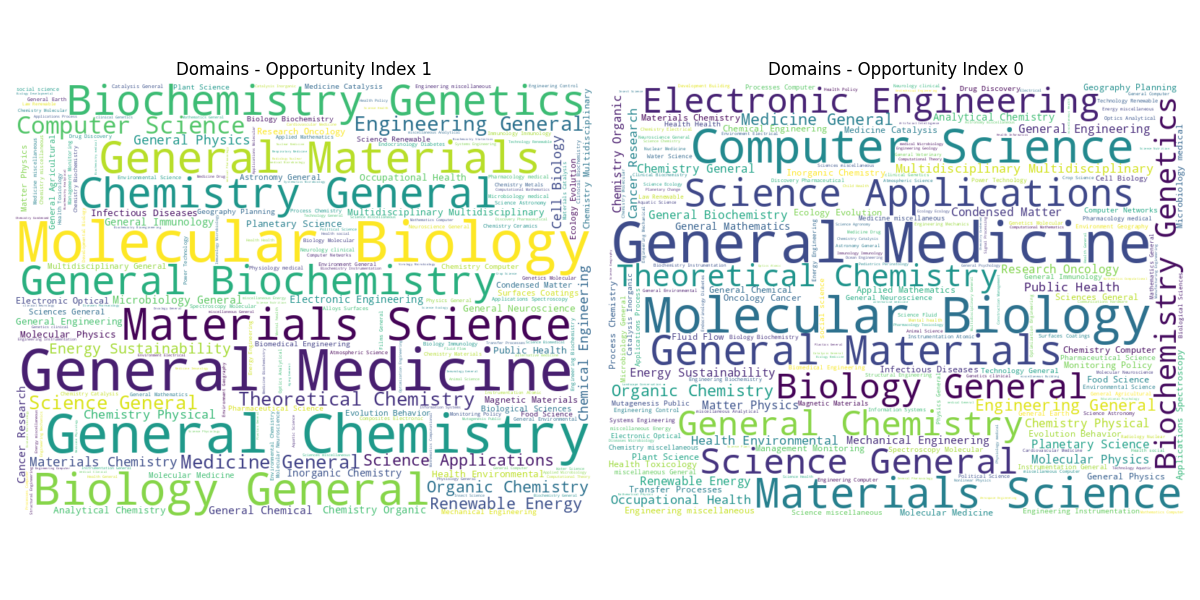

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import col

# Filter the DataFrame based on opportunity_index
df_opportunity_1 = df_cleaned.filter(col('opportunity_index') == 1.0)
df_opportunity_0 = df_cleaned.filter(col('opportunity_index') == 0.0)

# Convert the subject_list column to a list for word cloud generation
subject_list_1 = df_opportunity_1.select('subject_list').rdd.flatMap(lambda x: x[0]).collect()
subject_list_0 = df_opportunity_0.select('subject_list').rdd.flatMap(lambda x: x[0]).collect()

# Convert the lists to space-separated strings
subject_str_1 = ' '.join(subject_list_1)
subject_str_0 = ' '.join(subject_list_0)

# Create WordCloud objects
wordcloud_1 = WordCloud(width=800, height=600, background_color='white').generate(subject_str_1)
wordcloud_0 = WordCloud(width=800, height=600, background_color='white').generate(subject_str_0)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Domains - Opportunity Index 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Domains - Opportunity Index 0')
plt.axis('off')

plt.tight_layout()
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

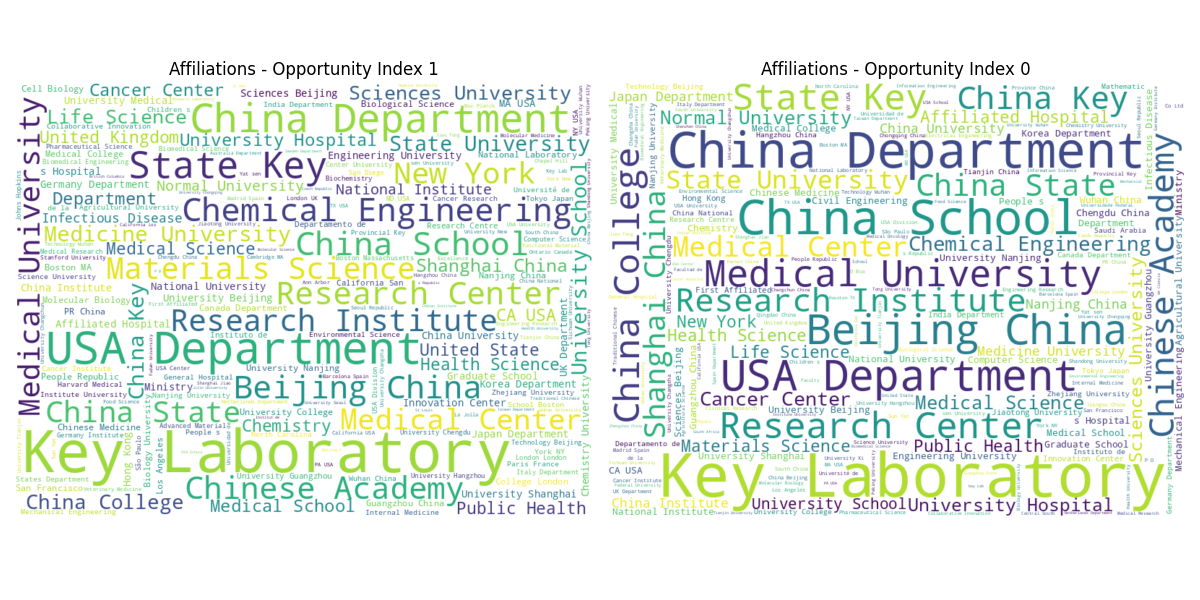

In [31]:
# Filter the DataFrame based on opportunity_index
df_opportunity_1 = df_cleaned.filter(col('opportunity_index') == 1.0)
df_opportunity_0 = df_cleaned.filter(col('opportunity_index') == 0.0)

# Convert the subject_list column to a list for word cloud generation
subject_list_1 = df_opportunity_1.select('affiliation_list').rdd.flatMap(lambda x: x[0]).collect()
subject_list_0 = df_opportunity_0.select('affiliation_list').rdd.flatMap(lambda x: x[0]).collect()

# Convert the lists to space-separated strings
subject_str_1 = ' '.join(subject_list_1)
subject_str_0 = ' '.join(subject_list_0)

# Create WordCloud objects
wordcloud_1 = WordCloud(width=800, height=600, background_color='white').generate(subject_str_1)
wordcloud_0 = WordCloud(width=800, height=600, background_color='white').generate(subject_str_0)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Affiliations - Opportunity Index 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Affiliations - Opportunity Index 0')
plt.axis('off')

plt.tight_layout()
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

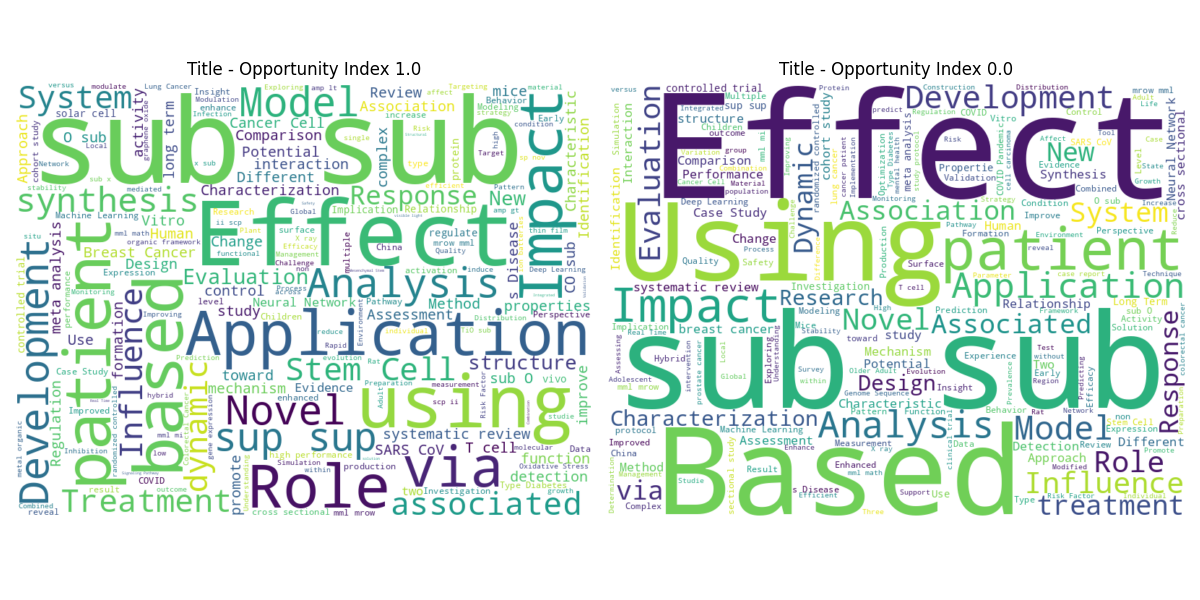

In [34]:
# Filter the DataFrame based on opportunity_index
df_opportunity_1 = df_cleaned.filter(col('opportunity_index') == 1.0)
df_opportunity_0 = df_cleaned.filter(col('opportunity_index') == 0.0)

# Extract the title strings from the DataFrame
title_str_1 = ' '.join([row.title for row in df_opportunity_1.select('title').collect()])
title_str_0 = ' '.join([row.title for row in df_opportunity_0.select('title').collect()])

# Create WordCloud objects
wordcloud_1 = WordCloud(width=800, height=600, background_color='white').generate(title_str_1)
wordcloud_0 = WordCloud(width=800, height=600, background_color='white').generate(title_str_0)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Title - Opportunity Index 1.0')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Title - Opportunity Index 0.0')
plt.axis('off')

plt.tight_layout()
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

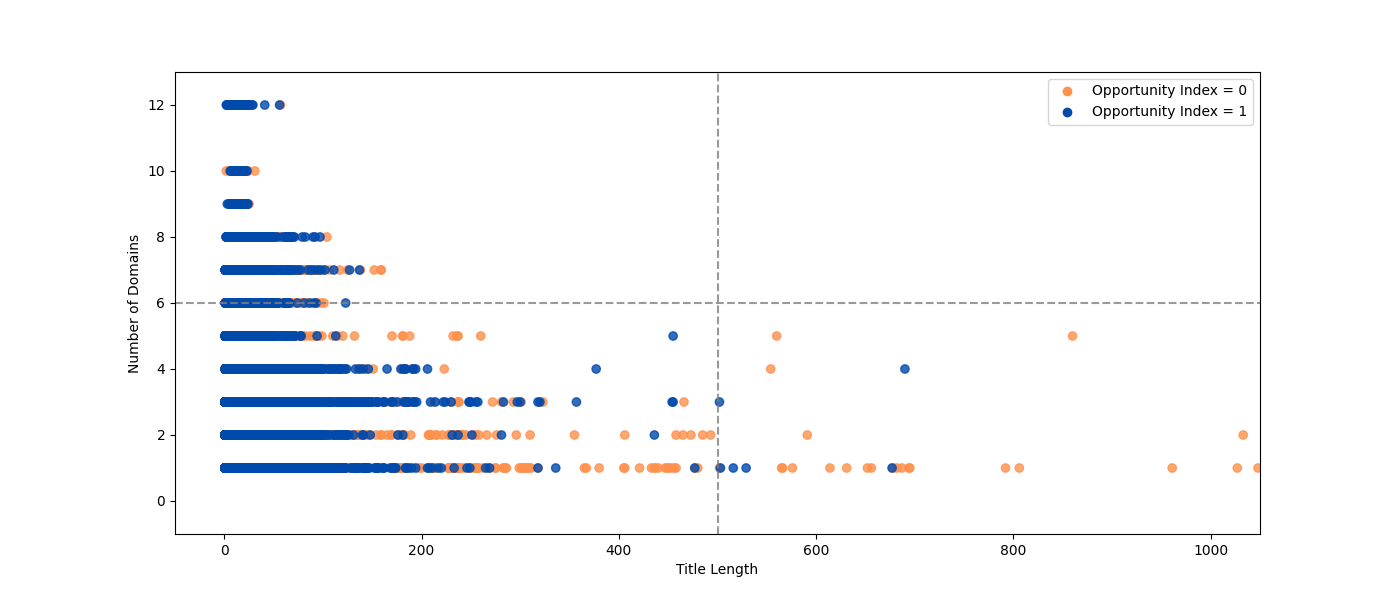

In [43]:
# Filter the DataFrame for plotting
df_plot = df_cleaned.select('title_token_length', 'num_subjects', 'opportunity_index')

# Extract the data as lists
x = df_plot.select('title_token_length').rdd.flatMap(lambda x: x).collect()
y = df_plot.select('num_subjects').rdd.flatMap(lambda x: x).collect()
opportunity_index = df_plot.select('opportunity_index').rdd.flatMap(lambda x: x).collect()

# Define the colors for opportunity_index (1.0: blue, 0.0: orange)
colors = {1.0: '#004AAD', 0.0: '#FF914D'}

# Create a scatter plot with opportunity_index as color and reduced opacity
plt.figure(figsize=(14, 6))
plt.scatter(x, y, c=[colors[idx] for idx in opportunity_index], alpha=0.8, label='Opportunity Index')

# Set axis labels
plt.xlabel('Title Length')
plt.ylabel('Number of Domains')

# Set x-axis limit to 1000
plt.xlim(-50, 1050)
plt.ylim(-1, 13)

# Add vertical and horizontal broken lines in the center
plt.axvline(x=500, color='gray', linestyle='dashed', linewidth=1.5, alpha=0.8)
plt.axhline(y=6, color='gray', linestyle='dashed', linewidth=1.5, alpha=0.8)

# Create the legend with the correct labels and colors
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0.0], label='Opportunity Index = 0', linestyle='None'),
    plt.Line2D([0], [0], marker='o', color=colors[1.0], label='Opportunity Index = 1', linestyle='None')
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

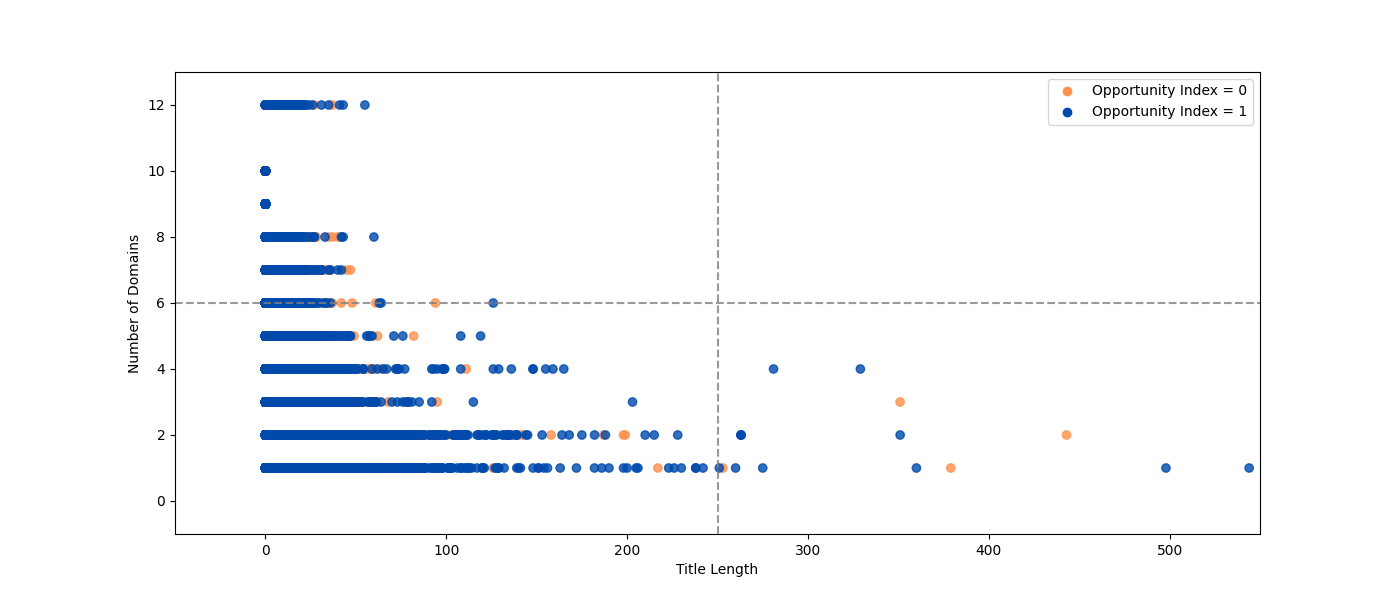

In [44]:
# Filter the DataFrame for plotting
df_plot = df_cleaned.select('num_affiliations', 'num_subjects', 'opportunity_index')

# Extract the data as lists
x = df_plot.select('num_affiliations').rdd.flatMap(lambda x: x).collect()
y = df_plot.select('num_subjects').rdd.flatMap(lambda x: x).collect()
opportunity_index = df_plot.select('opportunity_index').rdd.flatMap(lambda x: x).collect()

# Define the colors for opportunity_index (1.0: blue, 0.0: orange)
colors = {1.0: '#004AAD', 0.0: '#FF914D'}

# Create a scatter plot with opportunity_index as color and reduced opacity
plt.figure(figsize=(14, 6))
plt.scatter(x, y, c=[colors[idx] for idx in opportunity_index], alpha=0.8, label='Opportunity Index')

# Set axis labels
plt.xlabel('Title Length')
plt.ylabel('Number of Domains')

# Set x-axis limit to 1000
plt.xlim(-50, 550)
plt.ylim(-1, 13)

# Add vertical and horizontal broken lines in the center
plt.axvline(x=250, color='gray', linestyle='dashed', linewidth=1.5, alpha=0.8)
plt.axhline(y=6, color='gray', linestyle='dashed', linewidth=1.5, alpha=0.8)

# Create the legend with the correct labels and colors
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0.0], label='Opportunity Index = 0', linestyle='None'),
    plt.Line2D([0], [0], marker='o', color=colors[1.0], label='Opportunity Index = 1', linestyle='None')
]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()

%matplot plt